In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [58]:
import jax
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

plt.rcParams["figure.figsize"]=6,6

In [80]:
key = random.PRNGKey(12)

In [566]:
key, subkey = random.split(key)



# Number of 'batches'
B = 10000

# Number of images
N = 1000000

# Number of epochs
n_epoch = 1

# Averaging weight
beta = 0.9

# Regularization parameter
alpha = 0.01

# Update at the 'good' image
hx = 1

# Correct value
h_sol = 1/N + alpha

# Starting value
#h0 = jnp.abs(random.normal(subkey))
h0 = h_sol

### Exponential average

In [567]:
h_sol

0.010001

In [568]:
h = h0
h_all = [h]

for i in tqdm(range(n_epoch)):
    key, subkey = random.split(key)
    p = random.permutation(subkey, B)
    
    for i in range(B):
        if p[i] == 0:
            hi = hx * B/N + alpha
        else:
            hi = alpha 
            
        h = beta*h + (1-beta)*hi
        
        h_all.append(h)
        
h_all = jnp.array(h_all)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.21s/it]


gt = 0.010001
sol = 0.010000000000000002
alpha = 0.01


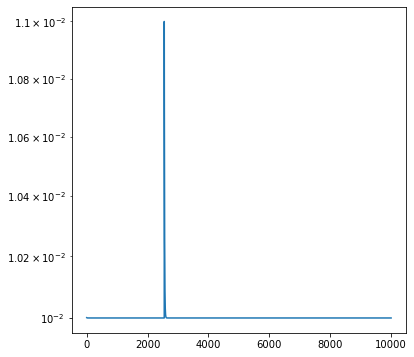

In [569]:
plt.semilogy(h_all)

print(f"gt = {h_sol}")
print(f"sol = {h_all[-1]}")
print(f"alpha = {alpha}")

In [570]:
jnp.max(h_all[2000:10000])

DeviceArray(0.011, dtype=float64)

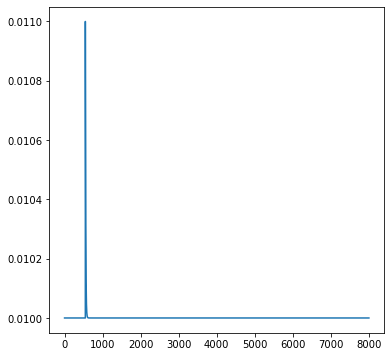

In [571]:
plt.plot(h_all[2000:10000])

### Arithmetic mean

In [572]:
h = h0
h_all = [h]

h_terms = [h]
n = 1
for i in tqdm(range(n_epoch)):
    key, subkey = random.split(key)
    p = random.permutation(subkey, B)
    
    for i in range(B):
        if p[i] == 0:
            hi = hx * B/N + alpha 
        else:
            hi = alpha 
            
        h_terms.append(hi)
        n += 1
        h = sum(h_terms)/n
        
        h_all.append(h)
        
h_all = jnp.array(h_all)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


gt = 0.010001
sol = 0.010001000000001425


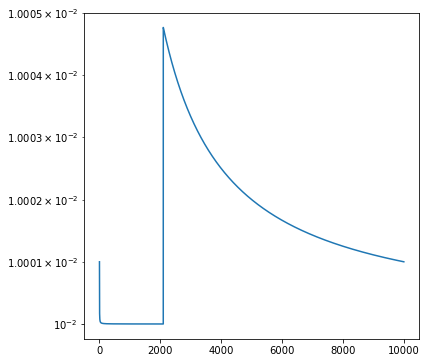

In [573]:
plt.semilogy(h_all)

print(f"gt = {h_sol}")
print(f"sol = {h_all[-1]}")
#print(f"alpha*B/N = {alpha*B/N}")
#print(f"(hx+alpha)*B/N = {(hx+alpha)*B/N}")

### Arithmetic mean with memory 

In [578]:
beta = 0.99

h = 100
h_all = [h]

h_terms = []
n = 0
for i in tqdm(range(n_epoch)):
    key, subkey = random.split(key)
    p = random.permutation(subkey, B)
    
    for i in range(B):
        if p[i] == 0:
            hi = hx * B/N + alpha 
        else:
            hi = alpha 
            
        h_terms.append(hi)
        n += 1
        h_new = sum(h_terms)/n
        
        h = beta*h + (1-beta)*h_new

        
        h_all.append(h)
        
h_all = jnp.array(h_all)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it]


gt = 0.010001
sol = 0.010001010103138534


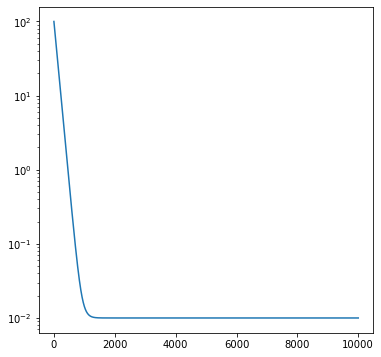

In [579]:
plt.semilogy(h_all)

print(f"gt = {h_sol}")
print(f"sol = {h_all[-1]}")
#print(f"alpha*B/N = {alpha*B/N}")
#print(f"(hx+alpha)*B/N = {(hx+alpha)*B/N}")